# Import Package, and Func.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import qiskit.quantum_info as qi

#from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature import settings
from qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
import pickle


In [2]:
def reset_intermediate_info():
    global intermediate_info
    intermediate_info.clear()
    print(intermediate_info)
    intermediate_info = {
        'nfev ': [],
        'parameters ': [],
        'energy ': [],
        'stddev ': []
    }


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

def fermion_to_qubit(problem, second_q_op, mapper_name,  z2symmetry_reduction=None):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(second_q_op)
  else :
    qubit_op = mapper.map(second_q_op)

  return qubit_op , mapper

def callback (nfev , parameters , energy , stddev ):
    intermediate_info ['nfev ']. append ( nfev )
    intermediate_info ['parameters ']. append ( parameters )
    intermediate_info ['energy ']. append ( energy )
    intermediate_info ['stddev ']. append ( stddev )



def least_Energy(as_problem):
    as_num_particles = as_problem.num_particles
    as_num_spatial_orbitals = as_problem.num_spatial_orbitals
    as_fermionic_hamiltonian = as_problem.hamiltonian
    as_second_q_op = as_fermionic_hamiltonian.second_q_op()
    energy_arr = []
    ansatz_order = []
    opt_order=[]
    qubit_op, mapper = fermion_to_qubit(as_problem, as_second_q_op, "Pa", z2symmetry_reduction=None)
    as_init_state = HartreeFock(as_num_spatial_orbitals,as_num_particles,mapper)
    uccsd = UCCSD(as_num_spatial_orbitals,as_num_particles,mapper,initial_state=as_init_state, generalized=True)
    twolocal = TwoLocal(as_num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=as_init_state)
    ansatzs=[uccsd,twolocal]
    iter = [250,1000]
    ansatzs_name=['UCCSD','Two local']
    
    opt_names = ['COBYLA','SPSA','L-BFGS-B'] 
    noiseless_estimator = Estimator()
    for i in range(2):
        ansatz = ansatzs[i]
        ansatz_name= ansatzs_name[i]
        MAX_ITER = iter[i]
        opt_arr = [COBYLA(maxiter=MAX_ITER),SPSA(maxiter=MAX_ITER),L_BFGS_B(maxiter=MAX_ITER)]
        for k in range(3):
            reset_intermediate_info()
            optimizer = opt_arr[k]
            opt_name = opt_names[k]
            vqe = VQE(noiseless_estimator, ansatz, optimizer, callback = callback)
            result = vqe.compute_minimum_eigenvalue(qubit_op)
            # electronic_structure_result = as_problem.interpret(result)

            core = as_problem.hamiltonian.constants['ActiveSpaceTransformer']
            repulsion = as_problem.hamiltonian.constants['nuclear_repulsion_energy']

            vqe_result = result.eigenvalue.real #+shift

            exact_energy = exact_solver(qubit_op, as_problem).total_energies[0].real

            # convergence_energy = intermediate_info['energy '][-1]
            dimer_energy = vqe_result+repulsion + core
            Co_Li_energy = dimer_energy

            energy_arr.append(Co_Li_energy)
            ansatz_order.append(ansatz_name)
            opt_order.append(opt_name)
            
            plt.plot(range(len(intermediate_info['energy '])), intermediate_info['energy ']+repulsion + core )
            plt.axhline(exact_energy, color = 'r', linewidth = 1, label = 'exact energy')
            plt.title('{0},{1}'.format(ansatz_name , opt_name))
            plt.xlabel('VQE Iterations')
            plt.ylabel('Energy')
            plt.grid()
            plt.legend()
            plt.show()
    
    return energy_arr, ansatz_order, opt_order

In [3]:
intermediate_info = {
'nfev ': [],
'parameters ': [],
'energy ': [],
'stddev ': []
}

basis = 'sto3g'
settings.use_pauli_sum_op = False

C = 1.9059
L = 2.07
theta = np.deg2rad(95.07)

Co = (0,0,0)
O_1 = (C,0,0)
O_2 = (C*np.cos(theta),C*np.sin(theta),0)
Li = (C+L*np.cos(np.pi-theta),-L*np.sin(np.pi-theta),0)

# Energy calc.

## 1. O-Li(near, bonding)

/var/folders/ym/2mkphtxj6yl3s830m3rpnw8c0000gn/T/ipykernel_14575/609710167.py:61: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  noiseless_estimator = Estimator()


{}


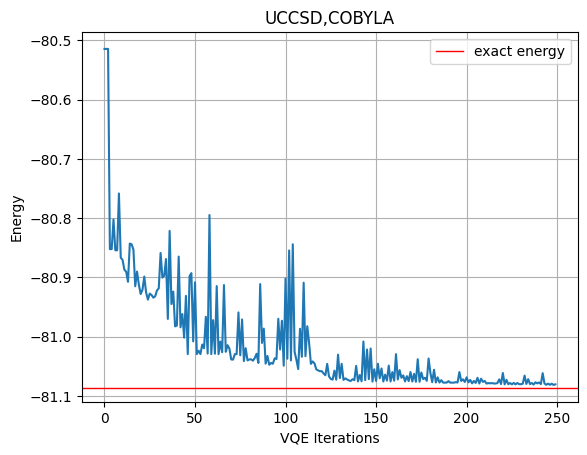

{}


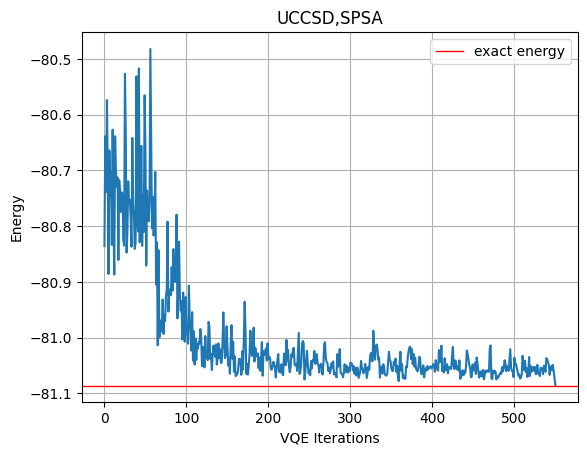

{}


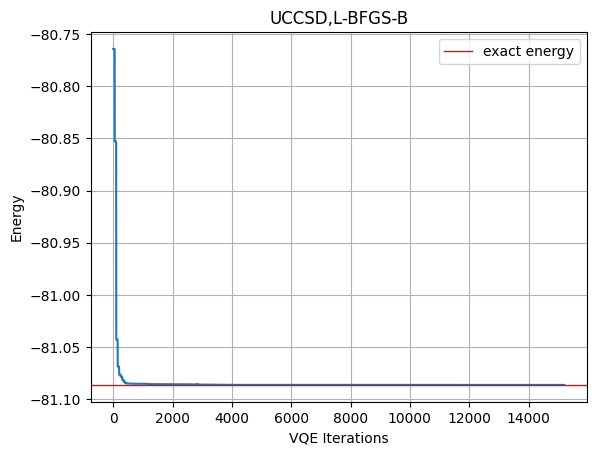

{}


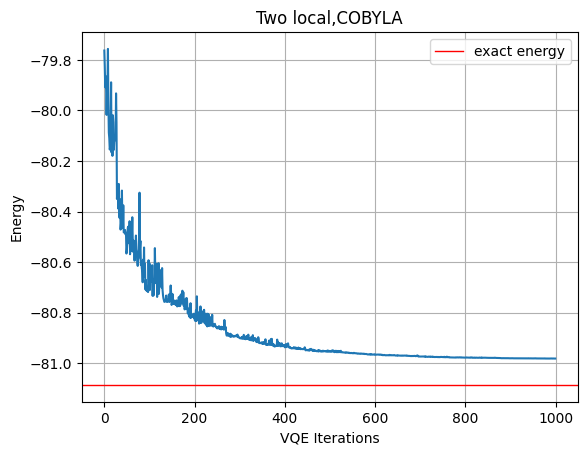

{}


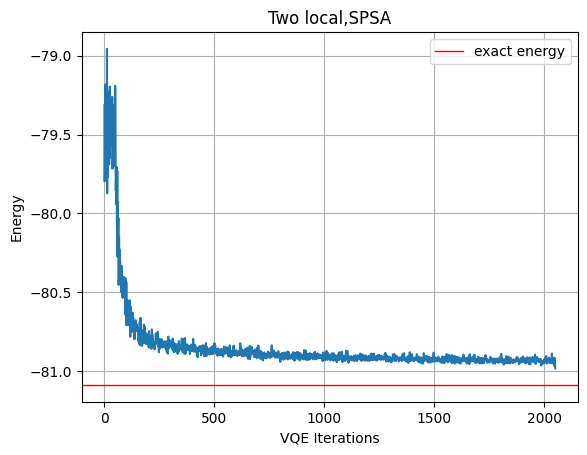

{}


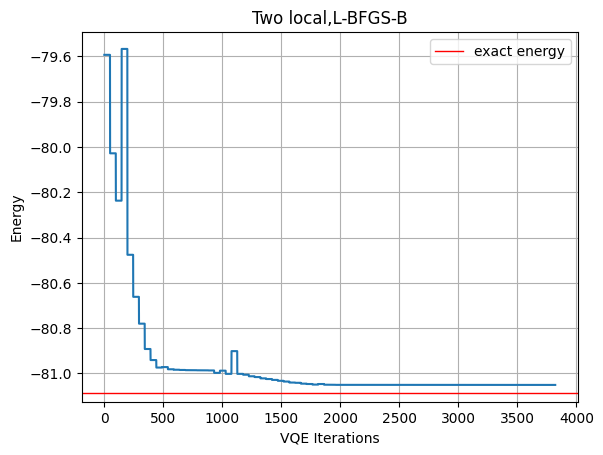

[np.float64(-81.08139547036875), np.float64(-81.08475429537947), np.float64(-81.08630998109665), np.float64(-80.98194163513364), np.float64(-80.98170115252974), np.float64(-81.05109214808593)]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -81.08630998109665


In [4]:
molecule_name = 'O-Li'

O_Li_dimer_atoms = ["O", "Li"]
O_Li_dimer_coords = [O_1, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 2

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)

energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((3,2), 4)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)
        
O_Li_dimer_energy=e

## 2. O--Li(far, non-bonding)

/var/folders/ym/2mkphtxj6yl3s830m3rpnw8c0000gn/T/ipykernel_14575/609710167.py:61: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  noiseless_estimator = Estimator()


{}


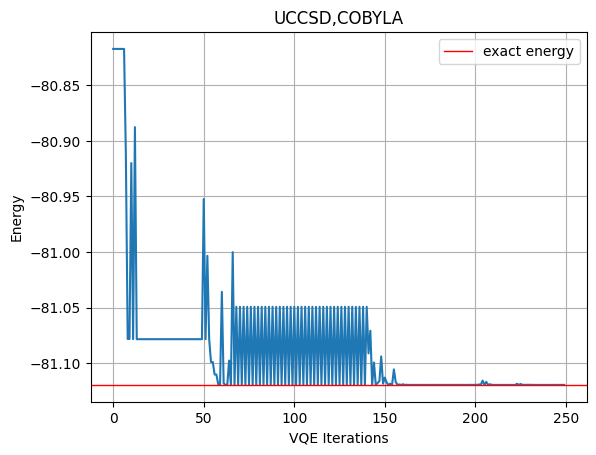

{}


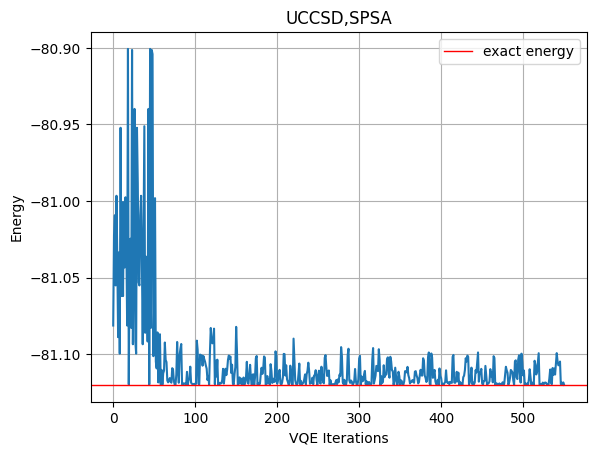

{}


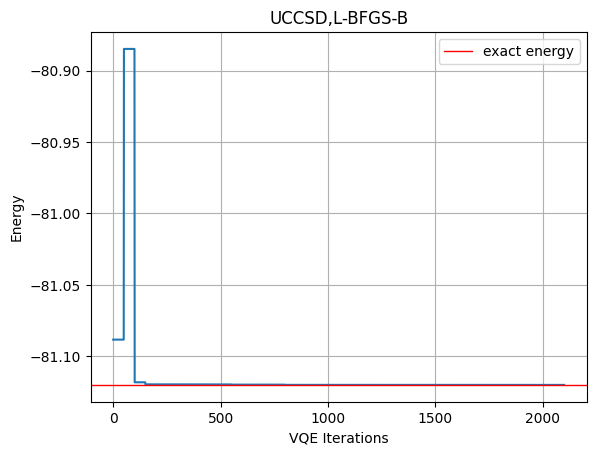

{}


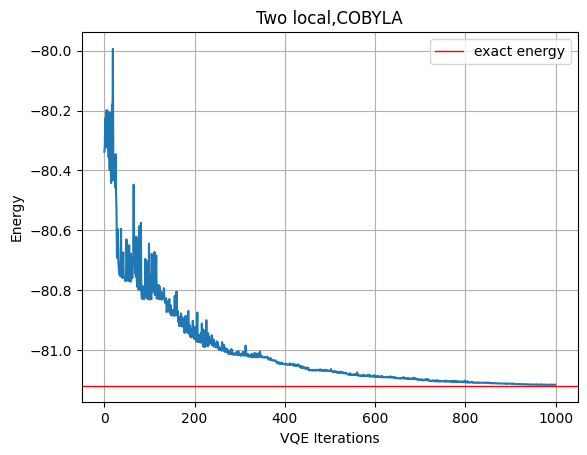

{}


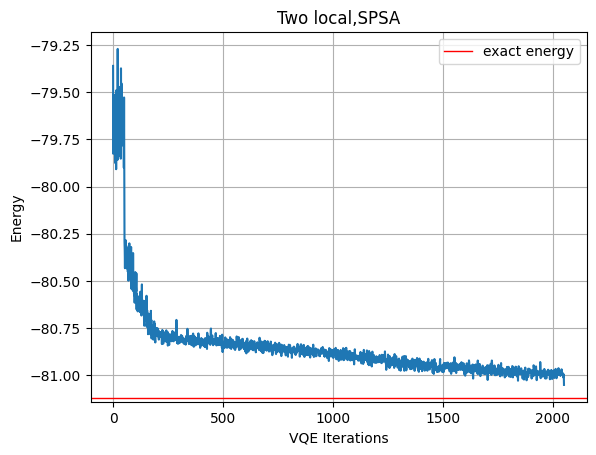

{}


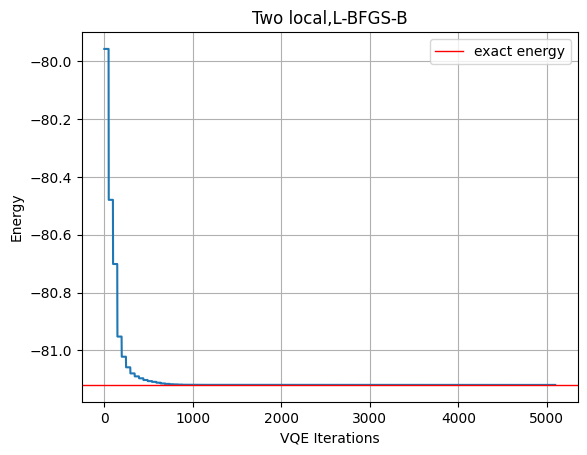

[np.float64(-81.11972127806851), np.float64(-81.1200247741412), np.float64(-81.12008806421602), np.float64(-81.11633623777885), np.float64(-81.05135529299808), np.float64(-81.11981989444953)]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -81.12008806421602


In [5]:
molecule_name = 'Li~O'

O_Li_dimer_atoms = ["O", "Li"]
O_Li_dimer_coords = [O_2, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 4

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)

driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((4,1), 4)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem,)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)

O_Li_2_dimer_energy=e